In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.set_num_threads(1)
import networkx as nx

from utils import projection_order1, mask_from_order
from data_generator import data_generator,generate_DAG, generator_matrix
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)
import opt
import time
from tqdm import tqdm

In [2]:
seed = 0
torch.random.manual_seed(seed)
np.random.seed(seed)
B_scale = 1.0 
B_ranges = ((B_scale * -1.0, B_scale * -0.05), (B_scale * 0.05, B_scale * 1.0))
n_test = 10000
d = 10
degree = 2
graph_type = 'ER'
noise_type = 'gaussian_ev'
DAG = generate_DAG(d, graph_type, degree, B_ranges, hd = False, seed=seed)
assert nx.is_directed_acyclic_graph(nx.DiGraph(DAG.B))
B = torch.tensor(DAG.B).to(device)
GM = generator_matrix(B)
X_test = data_generator(generator_matrix=GM, bs=n_test, noise_type=noise_type, seed=seed).to(device)
X = data_generator(generator_matrix=GM, bs=5000, noise_type=noise_type, seed=seed).to(device)
testing = False
verbose = False

In [3]:
def full_loss_(X, B):
    return (0.5 / X.size()[0]) * torch.square(X - X @ B).sum()
true_order = projection_order1(B)
optimal_test_loss = full_loss_(X_test, B)

In [4]:
main_mask = torch.eye(d).to(device) == 0
D0 = torch.zeros(d,d).to(device) * main_mask
true_distance = (D0-B).norm()
distance = torch.ceil(true_distance )

In [5]:
@torch.no_grad()
def full_loss(D):
    return (0.5 / X_test.size()[0]) * torch.square(X_test - X_test @ D).sum()

def loss(D, bs, mask):
    x  = data_generator(GM, bs=bs).to(device)
    return 0.5/bs  * torch.square(x - x @ (D * mask)).sum() #+ 0.001* masked_D.norm(p=1) + 0.000 * masked_D.norm(p=2) ** 2

def quadratic_optimization(D, optimizer, num_iter, mask, loss=loss, full_loss=full_loss, bs=1, log_iter=100, testing=testing):
    losses_inside = []
    with torch.no_grad():
        D *= mask
    for i in range(num_iter):
        if i % log_iter == 0 and testing:
            losses_inside.append(full_loss(D).item())
        def closure():
            optimizer.zero_grad()
            return loss(D=D,bs=bs,mask=mask)
        optimizer.step(closure)
    with torch.no_grad():
        D *= mask
    return D, losses_inside
    
    

In [6]:
epochs = 10
num_iter_outer = 1000 
num_iter_inner = 1000
bs = 64
D = D0.clone().requires_grad_()
optimizer = opt.UniversalSGD([D], D=distance)
times = [0.]
main_losses = [full_loss(D).item()]
total_iters= (num_iter_outer+num_iter_inner)//2

In [7]:
for j in tqdm(range(epochs)):
    time_start = time.time()
    D, loss = quadratic_optimization(D,optimizer,num_iter_outer, mask=main_mask)
    with torch.no_grad():
        order = projection_order1(D)

        mask = mask_from_order(order, main_mask)
        
        time_end = time.time()
        times.append(times[-1]+(time_end-time_start))
        loss = full_loss(D * mask).item()
        main_losses.append(loss)
    
        time_start = time.time()
        
    D, loss = quadratic_optimization(D,optimizer,num_iter_inner, mask=mask)
    
    with torch.no_grad():
        time_end = time.time()
    
        times.append(times[-1]+(time_end-time_start ))
        loss = full_loss(D * mask).item()
        main_losses.append(loss)
        

100%|█████████████████████████████████████| 10/10 [00:34<00:00,  3.41s/it]


In [8]:
# import pickle
# with open('d=10_n=5000_ER2_gaussian_ev.pickle', 'wb') as handle:
#     pickle.dump((main_losses, times, optimal_test_loss, total_iters), handle, protocol=pickle.HIGHEST_PROTOCOL)


# with open('d=10_n=5000_ER2_gaussian_ev.pickle', 'rb') as handle:
#     main_losses, times, optimal_test_loss, total_iters = pickle.load(handle)

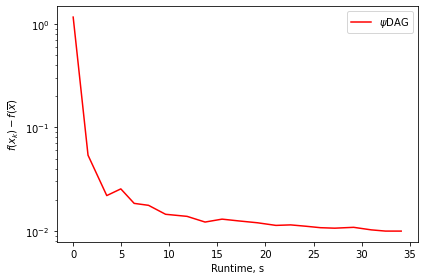

In [9]:
import matplotlib.pyplot as plt
import torch
plt.semilogy(times, torch.tensor(main_losses)-optimal_test_loss.cpu(), 'r', label= '$\psi$DAG')
plt.xlabel('Runtime, s')
plt.ylabel('$f(x_k)-f(\overline{x})$')
plt.legend()
plt.tight_layout()
plt.savefig('d=10_ER2_5000_gaussian_ev_time.pdf')

In [10]:
grads_iter1 = torch.tensor(range(len(main_losses)))
grads_iter1 *= 1000

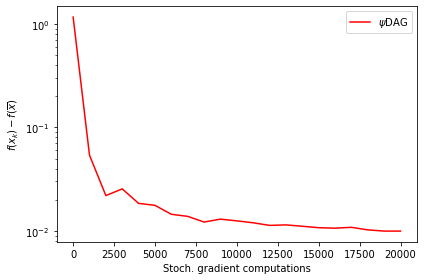

In [11]:
plt.semilogy(grads_iter1, torch.tensor(main_losses)-optimal_test_loss.cpu(), 'r', label= '$\psi$DAG')
plt.xlabel('Stoch. gradient computations')
plt.ylabel('$f(x_k)-f(\overline{x})$')
plt.legend()
plt.tight_layout()
plt.savefig('d=10_ER2_5000_gaussian_ev_iters.pdf')